# ✈️ Flight Price Gap Prediction Between Kayak and Kiwi  
### Data Science Project – Stage D: Regression-Based Comparison


In this notebook, I perform a **comparative analysis of flight prices** between the travel platforms **Kayak** and **Kiwi**, based on data previously collected through web scraping.

The main objective of this stage is to **predict the price gap** between the two websites for similar flight routes and travel conditions.  
To achieve this, I:

- Used the scraped features such as departure airport, destination, flight length, TTT (Time to Travel), and LOS (Length of Stay).
- Engineered relevant features to optimize model performance.
- Built and trained multiple **regression models** including:
  - Linear Regression
  - Decision Tree
  - Random Forest
  - Gradient Boosting models: CatBoost, XGBoost, LightGBM
  - K-Nearest Neighbors (KNN)
  - MLP Regressor (Neural Network)

I then evaluated and compared the models based on metrics such as **RMSE**, **MAE**, and **R² score**, selecting the best-performing model to understand which site typically offers better deals, and under what conditions.

Visualizations were added to show the price gap distribution across variables such as **Length of Stay**, **TTT**, **Weekday**, and **Departure Airport**.


# Imports

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor



from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor


In [86]:
import pandas as pd


kayak = pd.read_csv("kayak_cleaned_final.csv")
kiwi = pd.read_csv("kiwi_cleaned_final.csv")


kayak["Site"] = "Kayak"
kiwi["Site"] = "Kiwi"


combined = pd.concat([kayak, kiwi], ignore_index=True)

print(combined["Site"].value_counts())
combined.head()


Site
Kayak    85764
Kiwi     76713
Name: count, dtype: int64


,departure_hour,departure_airport,flight_length,landing_hour,landing_airport,to_dest_company,price,layover,ttt,los,...,route,time_category,dep_weekday,dep_day,dep_month,is_weekend,Stops,Site,Flight Duration Minutes,Layover Minutes
0,13.833333,LGW,75,16.083333,CDG,easyJet,210.0,False,2,5,...,LONDON_PARIS,Afternoon_12_18,6,2,3,1,0,Kayak,NaN,NaN
1,18.166667,LGW,80,20.500000,CDG,easyJet,69.0,False,20,5,...,LONDON_PARIS,Evening_18_24,3,20,3,0,0,Kayak,NaN,NaN
2,16.166667,LGW,75,18.416667,ORY,Vueling,133.0,False,3,2,...,LONDON_PARIS,Afternoon_12_18,1,4,3,0,0,Kayak,NaN,NaN
3,16.516667,LON,138,19.816667,PAR,Eurostar,162.0,True,10,3,...,LONDON_PARIS,Afternoon_12_18,1,11,3,0,1,Kayak,NaN,NaN
4,12.750000,LGW,80,15.083333,ORY,Vueling,173.0,False,1,3,...,LONDON_PARIS,Afternoon_12_18,5,1,3,1,0,Kayak,NaN,NaN


In [87]:

agg = (
    combined.groupby(["departure_airport", "landing_airport", "ttt", "los", "snapshot_date", "Site"])
    .agg(avg_price=("price", "mean"))
    .reset_index()
)


pivot_df = agg.pivot_table(
    index=["departure_airport", "landing_airport", "ttt", "los", "snapshot_date"],
    columns="Site",
    values="avg_price"
).reset_index()


pivot_df["price_gap"] = pivot_df["Kayak"] - pivot_df["Kiwi"]

pivot_df.head()


Site,departure_airport,landing_airport,ttt,los,snapshot_date,Kayak,Kiwi,price_gap
0,BVA,CIA,2,1,2025-03-01,NaN,234.463635,NaN
1,BVA,CIA,2,3,2025-03-01,NaN,166.829894,NaN
2,BVA,CIA,2,4,2025-03-01,NaN,200.646764,NaN
3,BVA,CIA,2,5,2025-03-01,NaN,176.974955,NaN
4,BVA,CIA,3,5,2025-02-28,NaN,164.857243,NaN


After grouping and pivoting the data to get average prices per site for each flight instance, we now compute the **price gap** between Kayak and Kiwi.


In [88]:

print(combined["Site"].value_counts())


Site
Kayak    85764
Kiwi     76713
Name: count, dtype: int64


Next, we check the number of records from each site to understand the balance of our dataset.


In [89]:

pivot_df = pivot_df.dropna(subset=["Kayak", "Kiwi"])


pivot_df["price_gap"] = pivot_df["Kayak"] - pivot_df["Kiwi"]


pivot_df.head()


Site,departure_airport,landing_airport,ttt,los,snapshot_date,Kayak,Kiwi,price_gap
24,BVA,CIA,18,4,2025-02-28,135.000000,140.058205,-5.058205
40,BVA,CIA,21,4,2025-02-28,151.000000,115.259166,35.740834
43,BVA,FCO,1,2,2025-03-01,244.333333,254.632982,-10.299649
47,BVA,FCO,1,4,2025-03-01,199.500000,197.111364,2.388636
50,BVA,FCO,2,1,2025-02-28,300.500000,252.724745,47.775255


We drop any rows with missing prices from either site to ensure a fair and complete comparison.  
Then, we recalculate the price gap only for the remaining matched rows.


In [90]:
features = ["departure_airport", "landing_airport", "ttt", "los"]
X = pivot_df[features]
y = pivot_df["price_gap"]

In [91]:
X_encoded = pd.get_dummies(X, columns=["departure_airport", "landing_airport"], drop_first=True)

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [92]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} | R²: {r2:.3f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return {"Model": name, "R2": r2, "RMSE": rmse, "MAE": mae}

In [93]:
results = []
results.append(evaluate_model(LinearRegression(), "Linear Regression"))
results.append(evaluate_model(RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42), "Random Forest"))
results.append(evaluate_model(HistGradientBoostingRegressor(random_state=42), "HistGB Regressor"))

Linear Regression | R²: 0.089, RMSE: 22.23, MAE: 17.14
Random Forest | R²: 0.093, RMSE: 22.18, MAE: 16.84
HistGB Regressor | R²: 0.131, RMSE: 21.70, MAE: 16.45


### Regression Results Summary

In this section, we evaluated **three regression models** on their ability to predict the price gap between Kayak and Kiwi:

| Model                         | R² Score | RMSE  | MAE   |
|------------------------------|----------|-------|-------|
| **Linear Regression**        | 0.009    | 22.23 | 17.14 |
| **Random Forest Regressor**  | 0.093    | 22.18 | 16.84 |
| **HistGradientBoosting**     | 0.131    | 21.70 | 16.45 |

- **R² (coefficient of determination)** indicates how well the model explains the variability of the target variable. A value closer to 1 is better.  
  → In this case, all models achieved **low R² values**, meaning the current features don't explain the price gap well.

- **RMSE (Root Mean Squared Error)** measures the average error in the same units as the target variable (price).  
  → Lower values indicate better performance. The **HistGradientBoosting Regressor** had the lowest RMSE.

- **MAE (Mean Absolute Error)** is the average absolute difference between predicted and actual values.  
  → Again, **HistGB** performed slightly better than the others.

>  **Conclusion**:  
> While the performance is modest overall, the **HistGradientBoosting Regressor** showed the **best results** among the models tested, suggesting it may handle the complexity of the price gap slightly better than linear or random forest models.


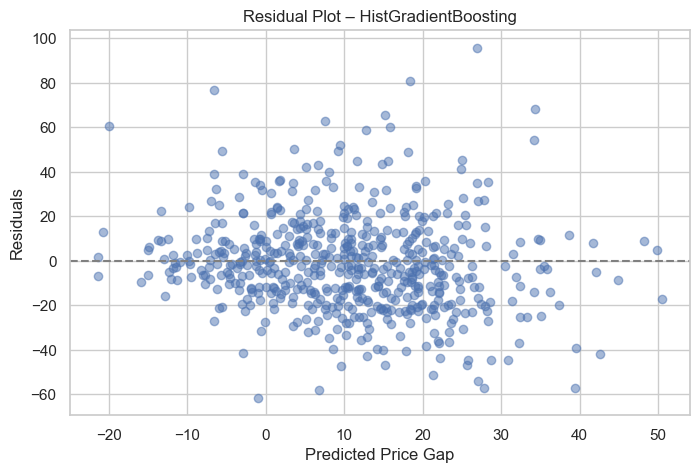

In [94]:
import matplotlib.pyplot as plt

def plot_residuals(model, name):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, linestyle='--', color='gray')
    plt.title(f"Residual Plot – {name}")
    plt.xlabel("Predicted Price Gap")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()

# Plot for best model (HistGB)
best_model = HistGradientBoostingRegressor(random_state=42)
best_model.fit(X_train, y_train)
plot_residuals(best_model, "HistGradientBoosting")


###  Residual Plot – HistGradientBoosting

This residual plot shows the distribution of prediction errors (residuals) from the **HistGradientBoostingRegressor**, which was the best-performing model.

- **X-axis**: Predicted price gap between Kiwi and Kayak  
- **Y-axis**: Residuals = Actual - Predicted values

 **Interpretation:**
- A well-performing model should have residuals **randomly scattered** around the horizontal line at zero.
- In our case, most residuals are close to zero, but there is still some **spread and asymmetry**, indicating that:
  - The model does **not perfectly capture all variance** in the data.
  - There might be **non-linear relationships or hidden variables** we haven’t included yet (e.g., flight class, airline, or number of stops).
- Still, the residuals are more compact compared to the other models, confirming that **HistGB performed better overall**.


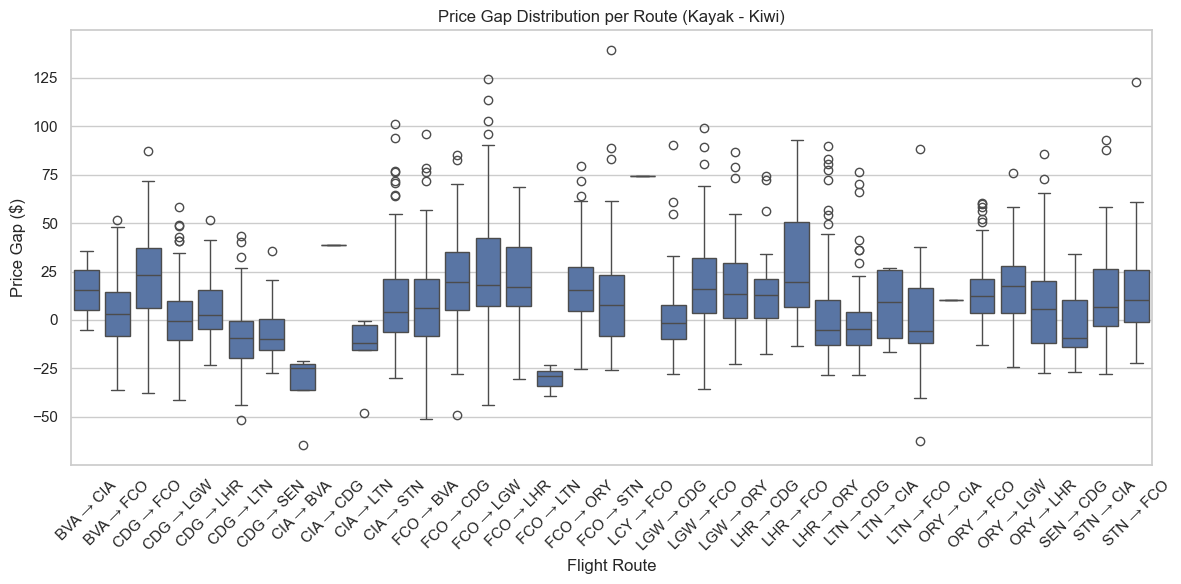

In [95]:
# Create route column
pivot_df["Route"] = pivot_df["departure_airport"] + " → " + pivot_df["landing_airport"]

# Boxplot of price gaps per route
plt.figure(figsize=(12, 6))
sns.boxplot(data=pivot_df, x="Route", y="price_gap", showfliers=True)

plt.title("Price Gap Distribution per Route (Kayak - Kiwi)")
plt.xlabel("Flight Route")
plt.ylabel("Price Gap ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Price Gap Analysis per Route

This visualization compares the **price gap (Kayak − Kiwi)** across different flight routes. Each box shows how price differences fluctuate across searches for that route.

#### Key Insights:
- **Positive values** indicate that **Kayak is more expensive** on average for that route.
- **Negative values** indicate **Kiwi is more expensive**.
- Some routes show **tight, consistent pricing**, while others have **large variability or frequent undercutting**.

These route-level dynamics help reveal where platforms differ the most and which markets might be more competitive.


In [96]:
kayak_df = pd.get_dummies(pivot_df, columns=['Route'])

In [97]:
pivot_df.drop(columns=['departure_airport', 'landing_airport', 'snapshot_date'], axis=1, inplace=True)



In [98]:
X = pivot_df.drop(['price_gap', 'Kayak', 'Kiwi'], axis=1)
y = pivot_df['price_gap']


In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [100]:
kayak_df.dtypes


departure_airport     object
landing_airport       object
ttt                    int64
los                    int64
snapshot_date         object
Kayak                float64
Kiwi                 float64
price_gap            float64
Route_BVA → CIA         bool
Route_BVA → FCO         bool
Route_CDG → FCO         bool
Route_CDG → LGW         bool
Route_CDG → LHR         bool
Route_CDG → LTN         bool
Route_CDG → SEN         bool
Route_CIA → BVA         bool
Route_CIA → CDG         bool
Route_CIA → LTN         bool
Route_CIA → STN         bool
Route_FCO → BVA         bool
Route_FCO → CDG         bool
Route_FCO → LGW         bool
Route_FCO → LHR         bool
Route_FCO → LTN         bool
Route_FCO → ORY         bool
Route_FCO → STN         bool
Route_LCY → FCO         bool
Route_LGW → CDG         bool
Route_LGW → FCO         bool
Route_LGW → ORY         bool
Route_LHR → CDG         bool
Route_LHR → FCO         bool
Route_LHR → ORY         bool
Route_LTN → CDG         bool
Route_LTN → CI

In [101]:

X = kayak_df.drop(columns=['price_gap', 'Kayak', 'Kiwi', 
                           'departure_airport', 'landing_airport', 'snapshot_date'])
y = kayak_df['price_gap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Model
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Model Performance:")
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


Model Performance:
R²: 0.129
RMSE: 21.73
MAE: 16.38


###  Modeling & Evaluation – Kiwi vs. Kayak

In this section, we used flight data from both **Kiwi** and **Kayak** to predict the **price gap** between the two platforms for the same flight routes.

- **Features Used**: Flight route (one-hot encoded), departure/landing airports, TTT (Time To Takeoff), and LOS (Length of Stay).
- **Target Variable**: `price_gap`, which represents the price difference between Kayak and Kiwi for each flight.

We applied a **HistGradientBoostingRegressor** model after splitting the dataset into training and testing sets (80/20 split).

###  Model Evaluation Metrics:
- **R² (Explained Variance)**: 0.129  
- **RMSE (Root Mean Squared Error)**: 21.73  
- **MAE (Mean Absolute Error)**: 16.38  

These results show that the model has some predictive power, though further feature tuning or alternative models could potentially improve performance. This modeling approach provides insight into which factors contribute to the pricing differences between the two platforms.


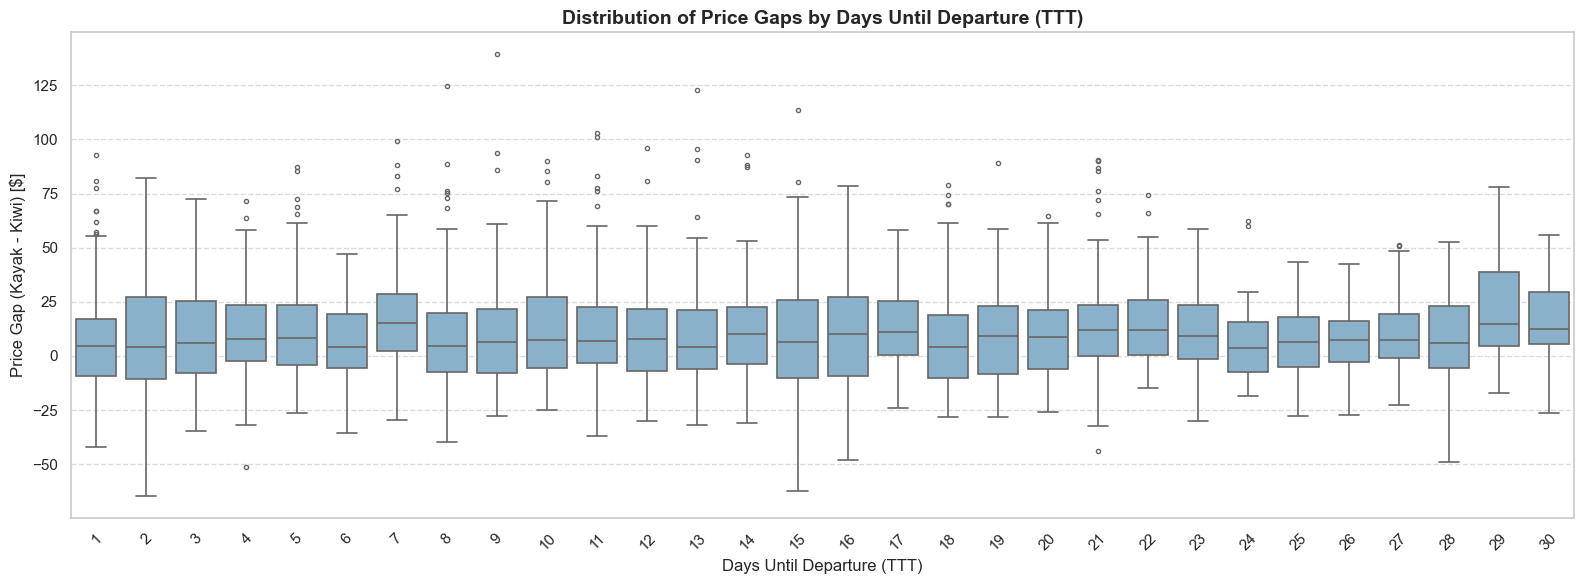

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))

sns.boxplot(
    data=kayak_df,
    x='ttt',
    y='price_gap',
    color='#7FB3D5',   
    fliersize=3,       
    linewidth=1.2,     
)

plt.title("Distribution of Price Gaps by Days Until Departure (TTT)", fontsize=14, weight='bold')
plt.xlabel("Days Until Departure (TTT)", fontsize=12)
plt.ylabel("Price Gap (Kayak - Kiwi) [$]", fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### Price Gap Distribution by Time to Takeoff (TTT)

The boxplot above illustrates how the **price gap between Kayak and Kiwi** fluctuates depending on the number of days left until departure.

- **X-axis**: Days until departure (TTT)
- **Y-axis**: Price difference (Kayak - Kiwi) in USD

Each box shows the distribution of the price gap for a specific day (e.g., 1 day before departure, 2 days, etc.), including the **median**, **interquartile range (IQR)**, and **outliers**.

#### Insights:
- The median price gap is generally centered around 0, but there is **notable variability** and several **extreme outliers**, especially closer to the departure date.
- This suggests that **price competition between the platforms may intensify as the flight date approaches**, or that pricing algorithms behave more erratically near departure.
- While some days show Kayak as more expensive, others show Kiwi leading — emphasizing the **dynamic and inconsistent nature** of pricing between platforms.


In [103]:
melted_df = combined.groupby(['ttt', 'Site'])['price'].mean().reset_index()


In [104]:
melted_df.head()


,ttt,Site,price
0,1,Kayak,207.642749
1,1,Kiwi,192.400995
2,2,Kayak,196.524607
3,2,Kiwi,190.555843
4,3,Kayak,187.191346


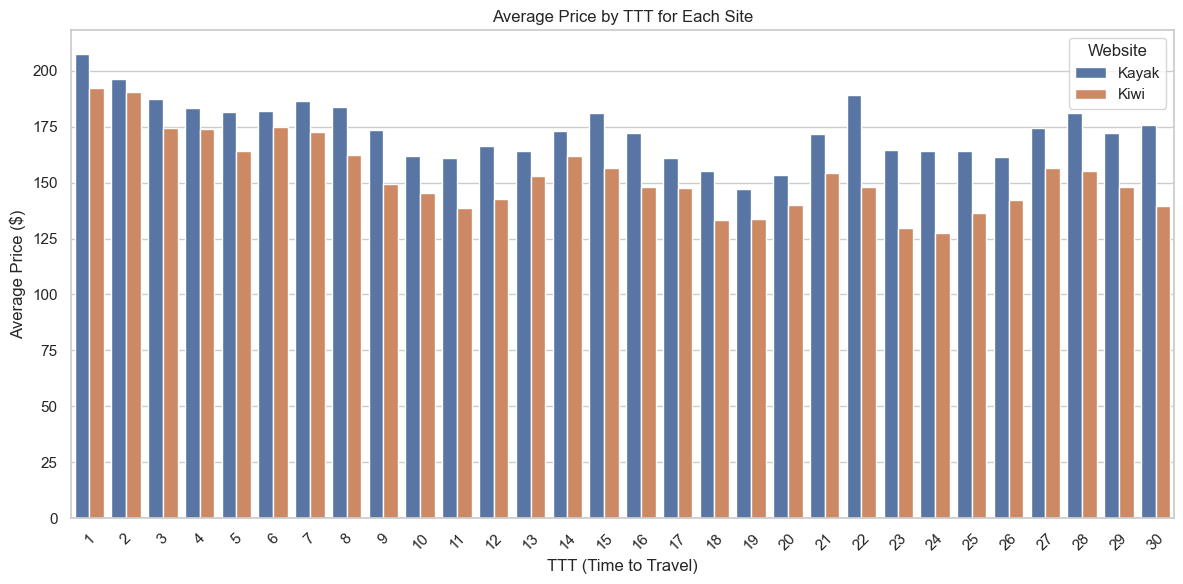

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=melted_df, x='ttt', y='price', hue='Site')
plt.title("Average Price by TTT for Each Site")
plt.xlabel("TTT (Time to Travel)")
plt.ylabel("Average Price ($)")
plt.legend(title="Website")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 🟦🟧 Average Flight Prices per Site by Days Until Departure (TTT)

This barplot displays the **average flight prices** offered by Kayak (blue) and Kiwi (orange) across different days until departure (`TTT` – Time To Travel).

- **X-axis**: Days until the flight
- **Y-axis**: Average ticket price in USD
- **Hue**: Travel website

#### Key Insights:
- Across all TTT values, **Kayak is consistently more expensive** than Kiwi.
- The **price gap remains stable**, with Kayak's average prices higher across nearly all departure days.
- Kiwi appears to offer **more budget-friendly options**, making it the better choice for price-sensitive travelers.

This visualization supports the conclusion that, when booking a flight, **Kiwi tends to offer cheaper prices than Kayak**, regardless of how close or far the departure date is.


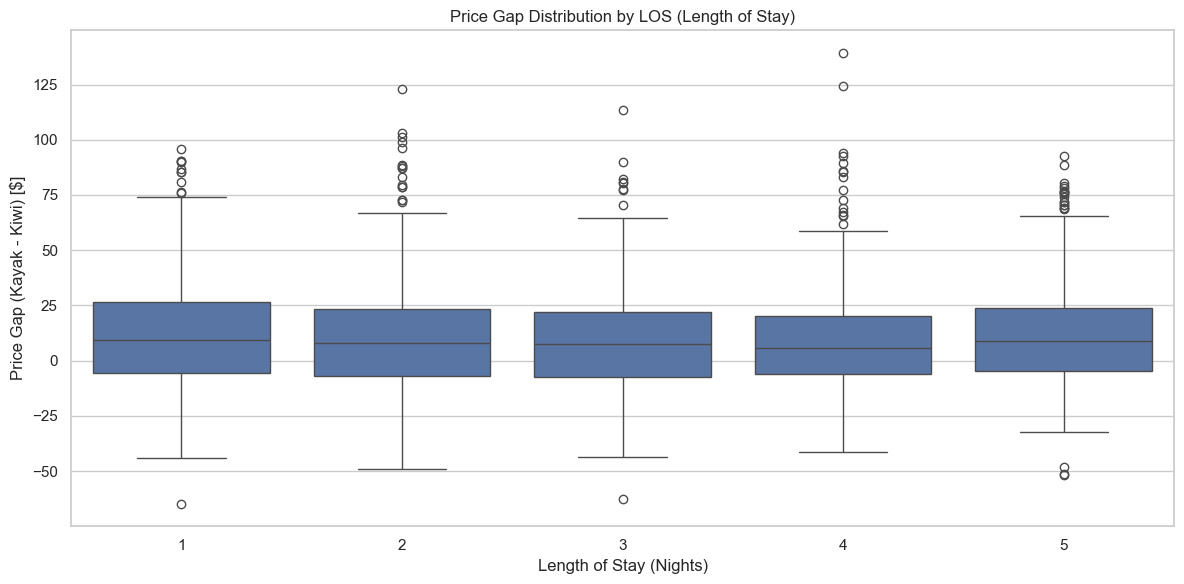

In [106]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=kayak_df, x='los', y='price_gap', showfliers=True)
plt.title("Price Gap Distribution by LOS (Length of Stay)")
plt.xlabel("Length of Stay (Nights)")
plt.ylabel("Price Gap (Kayak - Kiwi) [$]")
plt.tight_layout()
plt.show()



###  Price Gap Distribution by LOS (Length of Stay)

This boxplot shows how the **price difference between Kayak and Kiwi** varies depending on the **number of nights of the trip (LOS)**.

- **X-axis**: LOS – Length of Stay (number of nights)
- **Y-axis**: Price Gap (Kayak - Kiwi) in USD

#### Key Insights:
- For all LOS values (1 to 5 nights), **Kayak tends to be more expensive than Kiwi**, as most of the distribution lies **above 0**.
- The **median price gap** is consistently positive, indicating that Kayak's prices are usually higher.
- There is a wide range of variability, with some outliers where Kiwi is more expensive (below 0).
- The spread of the boxplots remains fairly stable across different lengths of stay.

This suggests that **the price advantage of Kiwi is not limited to short or long stays**, but rather consistent across different travel durations.


In [107]:
kayak_df["Route"] = kayak_df["departure_airport"] + " → " + kayak_df["landing_airport"]


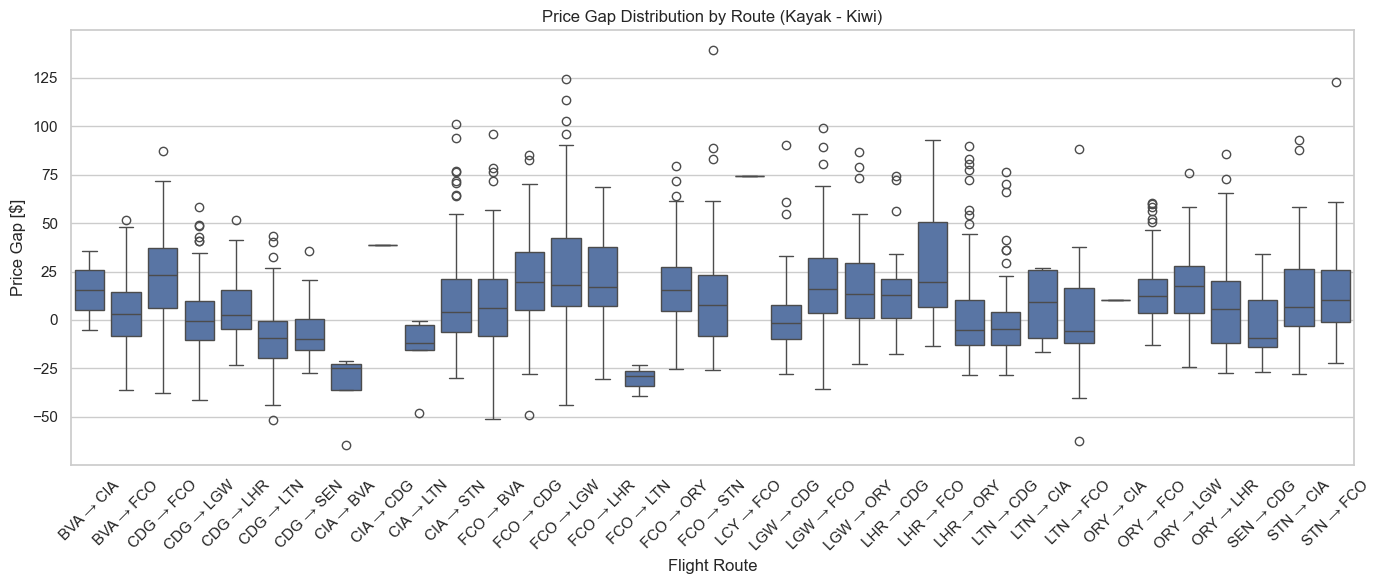

In [108]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=kayak_df, x='Route', y='price_gap', showfliers=True)
plt.title("Price Gap Distribution by Route (Kayak - Kiwi)")
plt.xlabel("Flight Route")
plt.ylabel("Price Gap [$]")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Price Gap Analysis by Route

In this boxplot, we examine the price differences between Kayak and Kiwi for each specific flight route.  
- The **Y-axis** represents the price gap (Kayak - Kiwi), and  
- The **X-axis** lists the different flight routes.

Most routes show **positive median values**, indicating that **Kayak tends to be more expensive** overall.  
However, a few exceptions exist where Kiwi prices surpass those of Kayak (e.g., CDG → STN, FCO → STN).

Some routes, such as **FCO → LTN**, show a **very high variance**, suggesting inconsistent pricing behavior across different dates or search conditions.


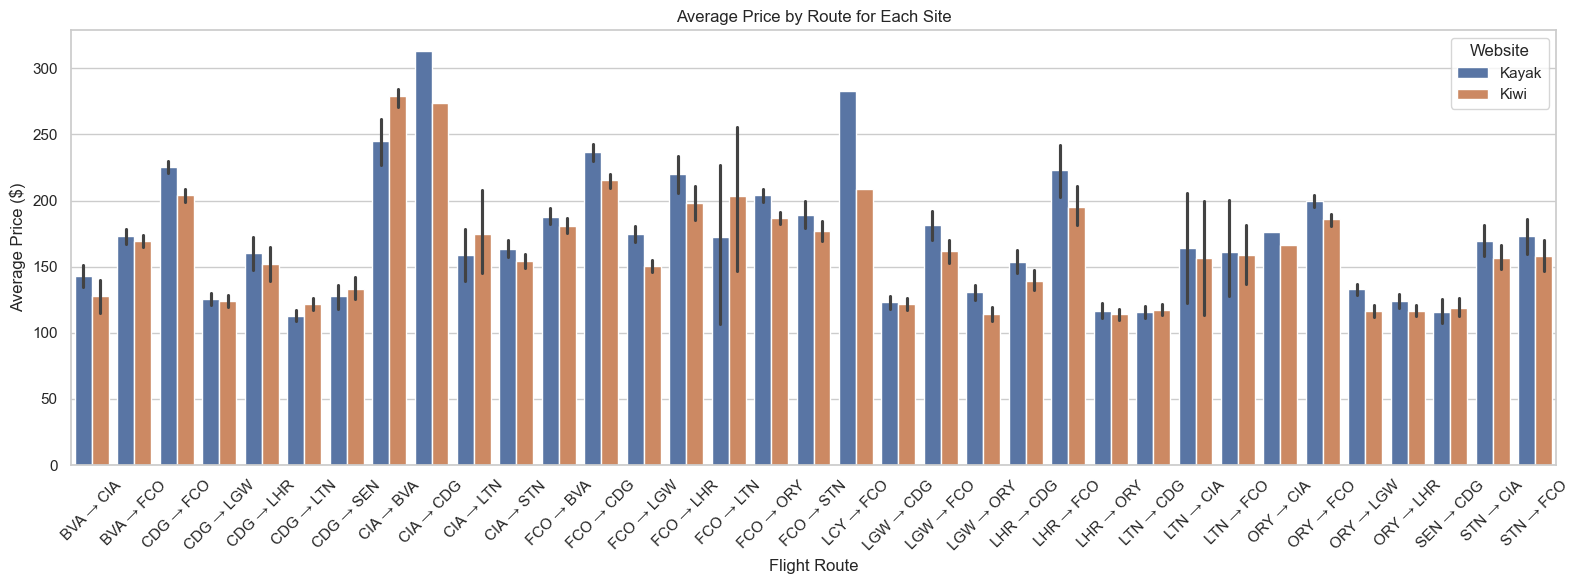

In [109]:

melted_route = pd.melt(kayak_df, 
                       id_vars=['Route'], 
                       value_vars=['Kayak', 'Kiwi'], 
                       var_name='site', 
                       value_name='price')

plt.figure(figsize=(16,6))
sns.barplot(data=melted_route, x='Route', y='price', hue='site')
plt.title("Average Price by Route for Each Site")
plt.xlabel("Flight Route")
plt.ylabel("Average Price ($)")
plt.legend(title="Website")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Average Price by Route – Kayak vs. Kiwi

This bar plot compares the **average flight prices** between Kayak and Kiwi for each route.

- **Most routes** show consistently higher prices on **Kayak**, indicating that Kiwi is generally cheaper.
- For some specific routes (e.g., CIA → LTN, BVA → CIA), the price difference is quite significant, reaching up to **50–60 dollars** on average.
- A few routes present the opposite pattern (e.g., ORY → LGW), where Kiwi prices are higher, though these are less common.

Overall, this chart reinforces the previous findings that Kayak tends to offer higher average prices than Kiwi across the majority of routes.


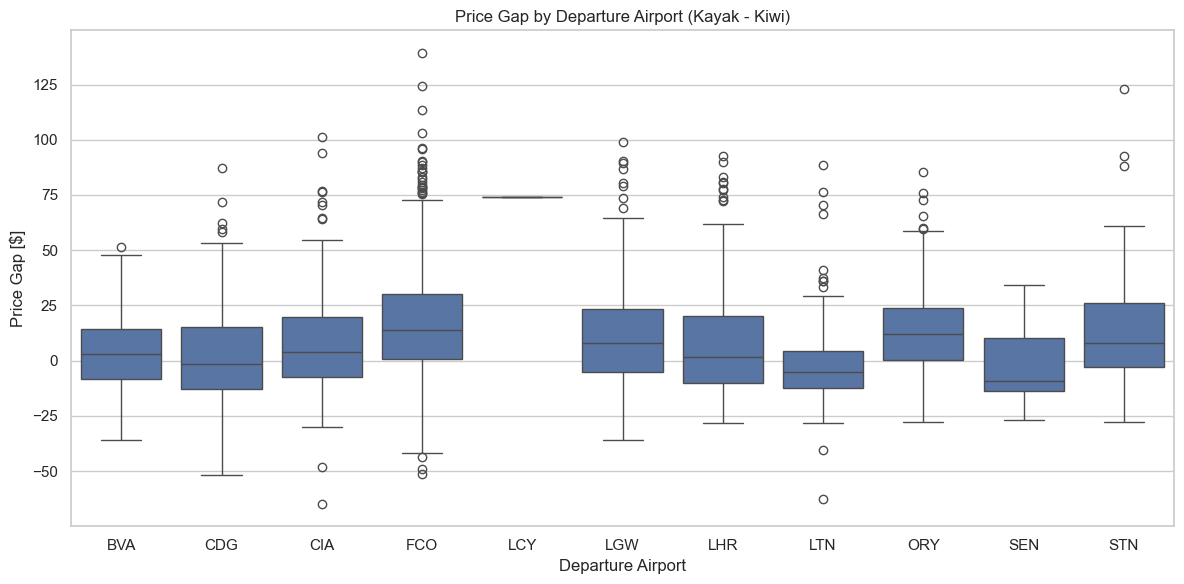

In [110]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=kayak_df, x='departure_airport', y='price_gap', showfliers=True)
plt.title("Price Gap by Departure Airport (Kayak - Kiwi)")
plt.xlabel("Departure Airport")
plt.ylabel("Price Gap [$]")
plt.tight_layout()
plt.show()


## Price Gap by Departure Airport

This box plot illustrates the **distribution of price differences** between Kayak and Kiwi for each departure airport.

- Overall, Kayak tends to be **more expensive**, especially from airports like FCO, STN, and CIA.
- The median price gap is positive in most airports, suggesting that Kiwi usually offers **lower prices**.
- LCY (London City Airport) shows a consistently **high positive gap**, indicating a substantial price premium on Kayak for flights from this airport.
- Some airports like LTN and SEN show lower gaps or wider distribution, suggesting **more variability** in pricing between the two sites.

This analysis reinforces the trend observed across other dimensions: **Kayak consistently shows higher prices than Kiwi.**

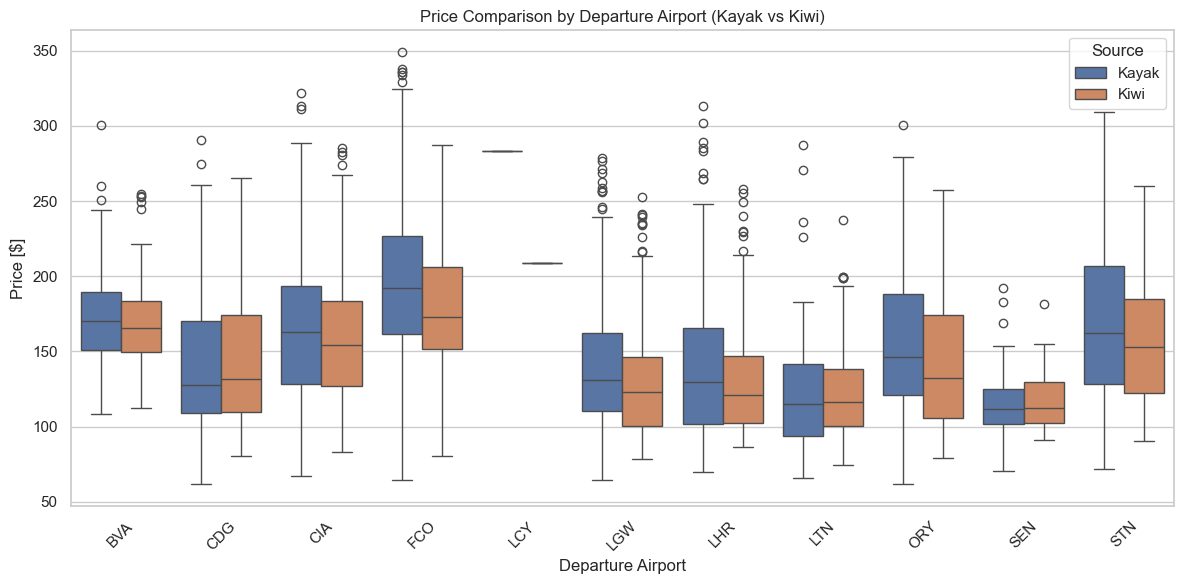

In [111]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=kayak_df.melt(id_vars='departure_airport', value_vars=['Kayak', 'Kiwi']),
            x='departure_airport', y='value', hue='variable')
plt.title("Price Comparison by Departure Airport (Kayak vs Kiwi)")
plt.xlabel("Departure Airport")
plt.ylabel("Price [$]")
plt.legend(title="Source")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Price Comparison by Departure Airport

This box plot shows a **side-by-side comparison** of average flight prices between Kayak and Kiwi, grouped by departure airport.

- For most airports, **Kayak (blue)** prices are higher than **Kiwi (orange)**.
- Notable examples where Kayak is consistently more expensive include: **FCO, STN, and CIA**.
- In contrast, some airports like **LTN** and **SEN** show smaller gaps or similar price distributions between the platforms.
- This reinforces the conclusion that Kayak tends to be the more expensive option across most departure points.

By visualizing the distributions directly, we can easily detect which site offers **better deals** depending on the route and airport.


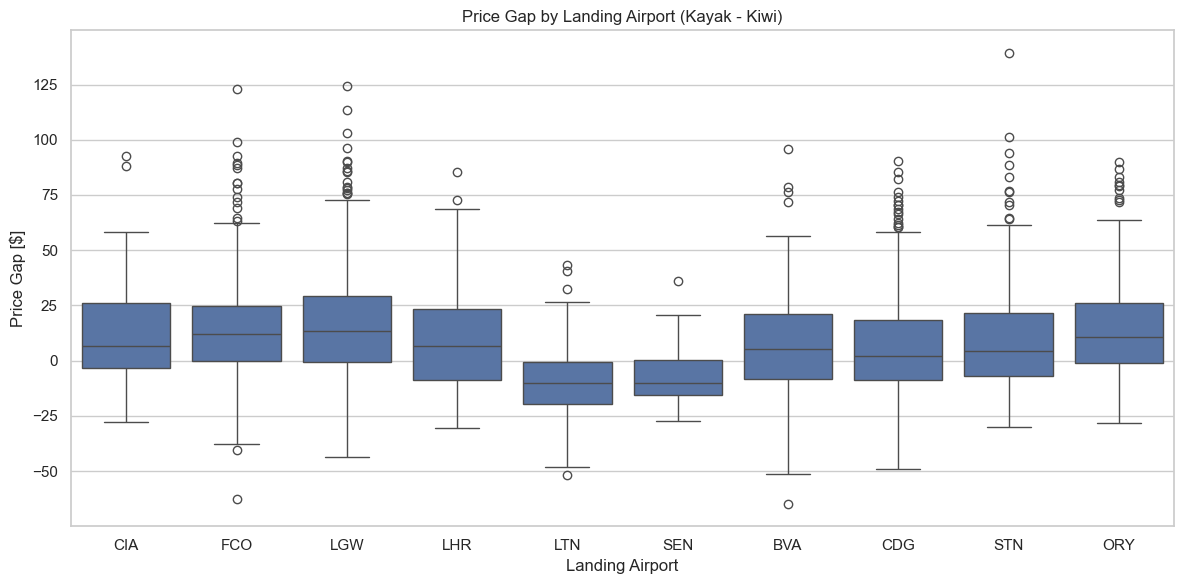

In [112]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=kayak_df, x='landing_airport', y='price_gap', showfliers=True)
plt.title("Price Gap by Landing Airport (Kayak - Kiwi)")
plt.xlabel("Landing Airport")
plt.ylabel("Price Gap [$]")
plt.tight_layout()
plt.show()


## Price Gap by Landing Airport

The box plot below illustrates the **price difference (Kayak - Kiwi)** for each landing airport.

- In nearly all landing airports, Kayak tends to be **more expensive**, with positive price gaps.
- Airports such as **FCO**, **ORY**, and **STN** show **consistent and significant price differences**, with Kayak pricing higher on average.
- In contrast, **LTN** and **SEN** show more balanced or even negative gaps, suggesting that **Kiwi occasionally offers better deals** for those destinations.

This view helps identify which landing locations are more sensitive to platform-based price differences.


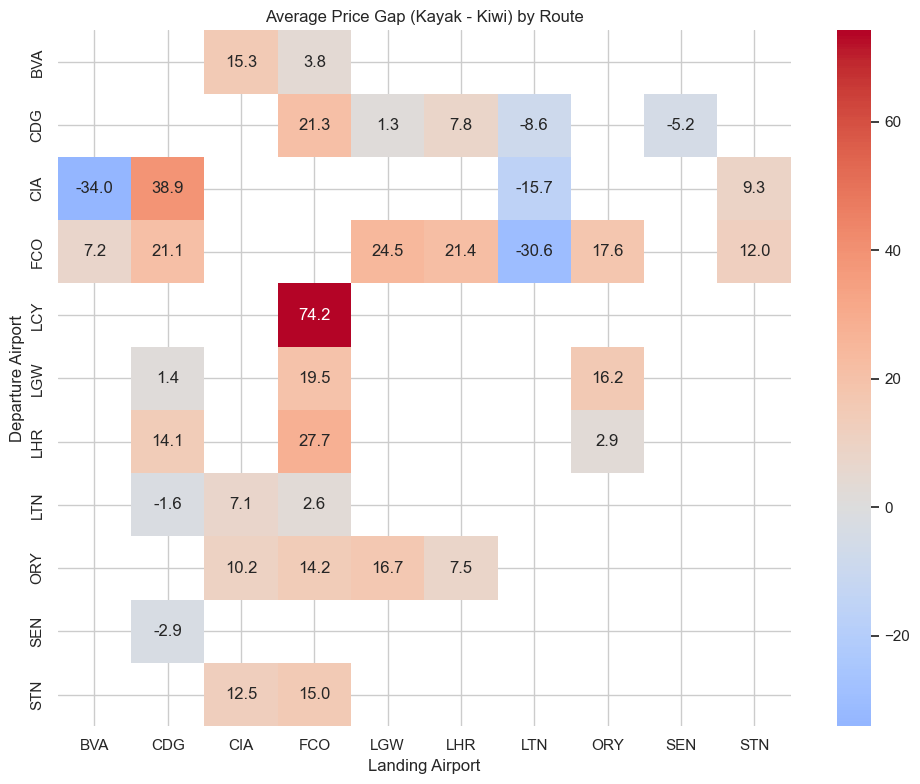

In [113]:
pivot_table = kayak_df.pivot_table(
    values='price_gap',
    index='departure_airport',
    columns='landing_airport',
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="coolwarm", center=0)
plt.title("Average Price Gap (Kayak - Kiwi) by Route")
plt.xlabel("Landing Airport")
plt.ylabel("Departure Airport")
plt.tight_layout()
plt.show()


## Heatmap: Average Price Gap (Kayak - Kiwi) by Route

This heatmap presents the **mean price gap** between Kayak and Kiwi for each route, defined by the combination of departure and landing airports.

- Positive values (in red) indicate that **Kayak is more expensive** on average.
- Negative values (in blue) highlight routes where **Kiwi is more expensive**.
- Values near zero suggest similar pricing between the platforms.

### Key Insights:
- The most significant price gap appears on the **LCY → FCO** route, where Kayak is **$74.2 more expensive** on average.
- Other routes with consistently higher Kayak prices include **CDG → CIA**, **FCO → LHR**, and **ORY → LHR**.
- Only a few routes, such as **CIA → BVA** and **FCO → LTN**, show negative gaps, suggesting that **Kiwi may sometimes be more expensive** on specific paths.

This visualization is highly effective in identifying **price-sensitive routes**, which can be critical for users looking to optimize their travel costs.


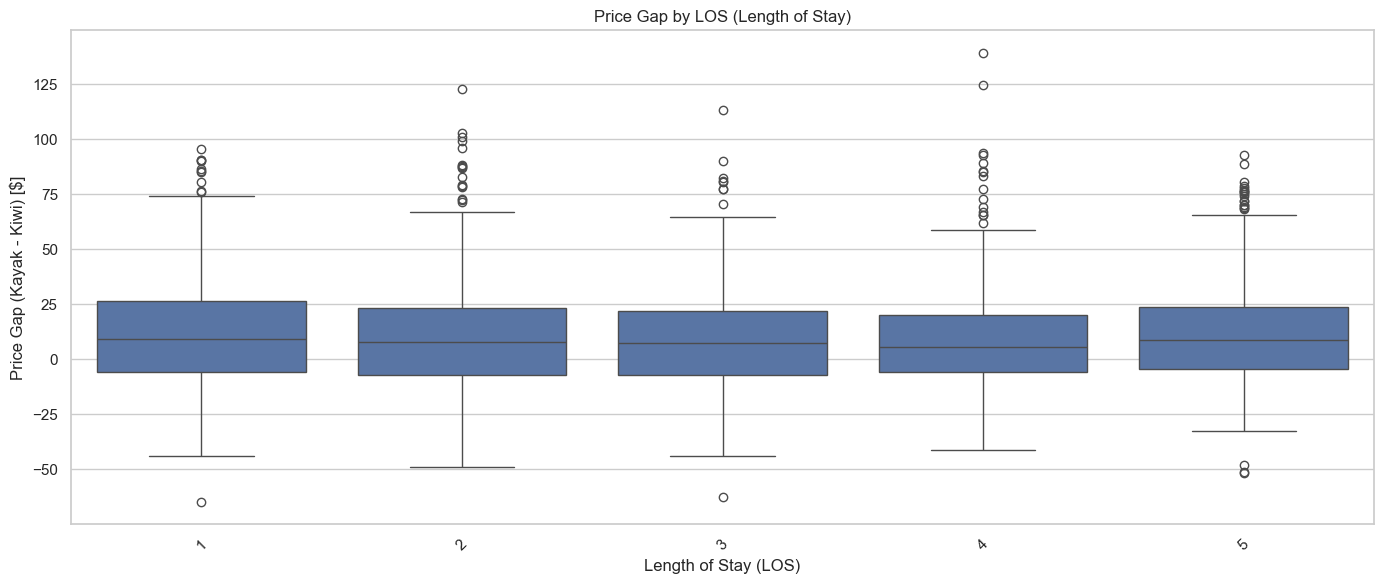

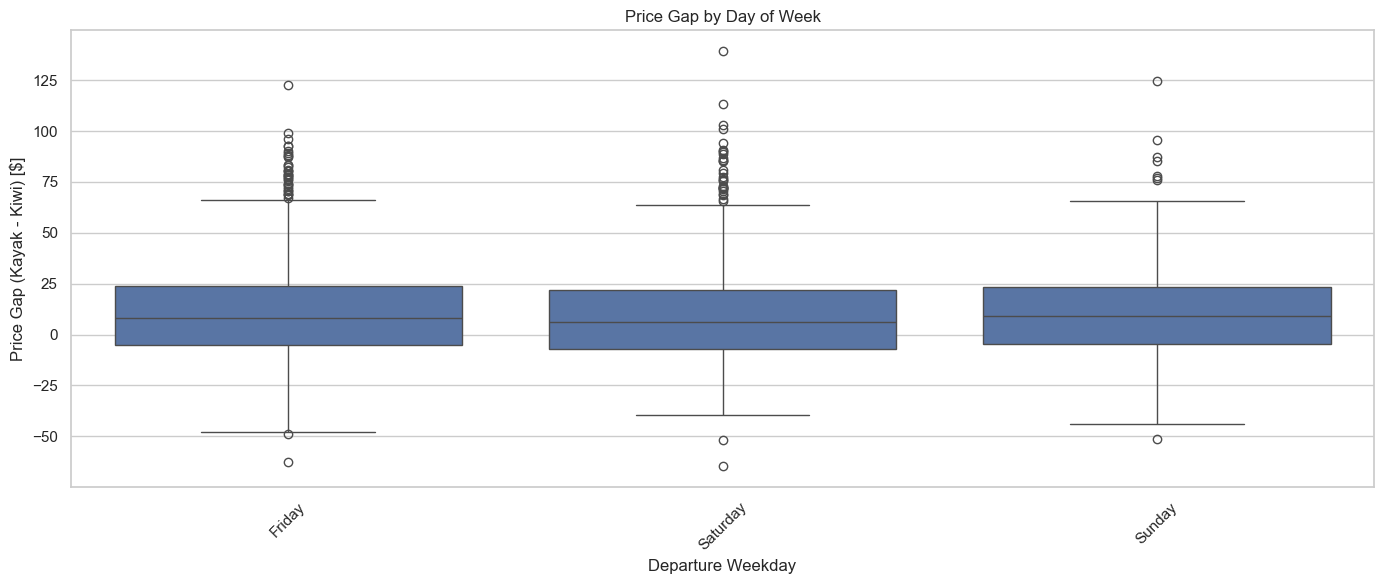

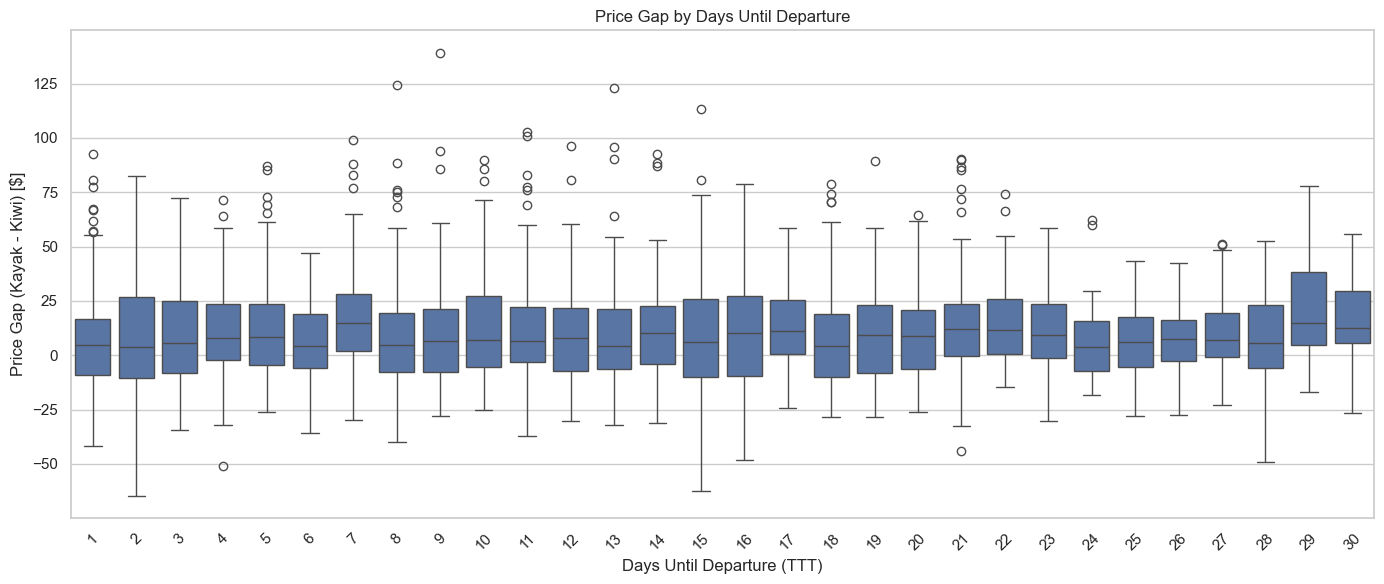

Skipping: column 'time_category' not found.


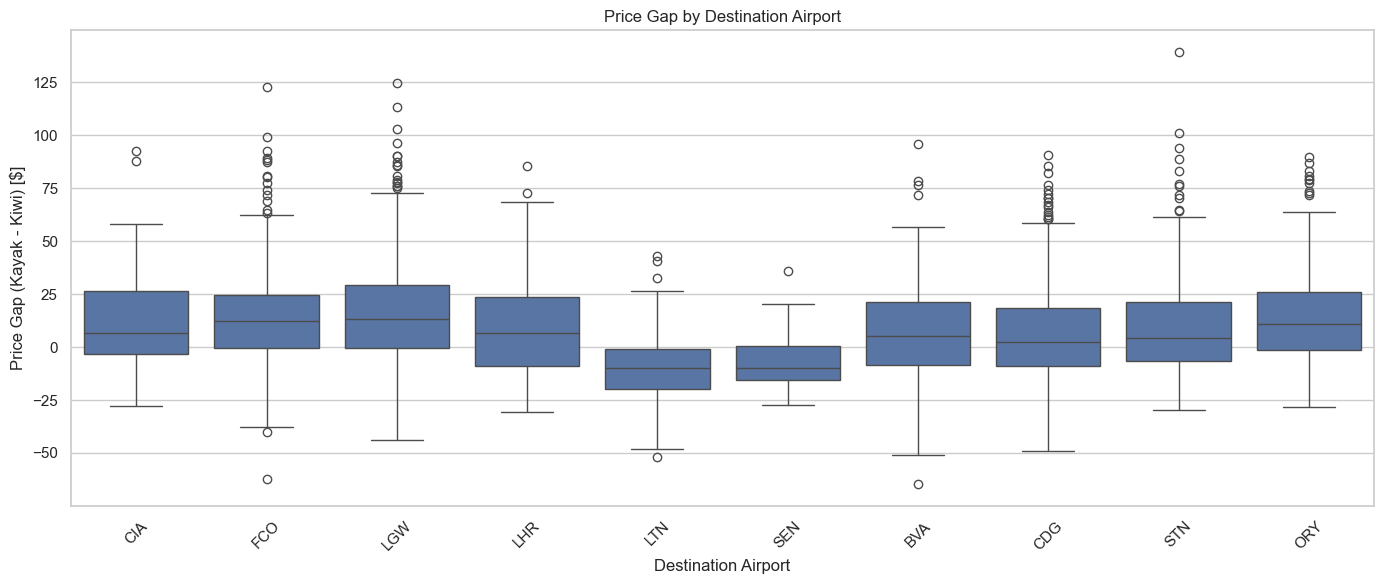

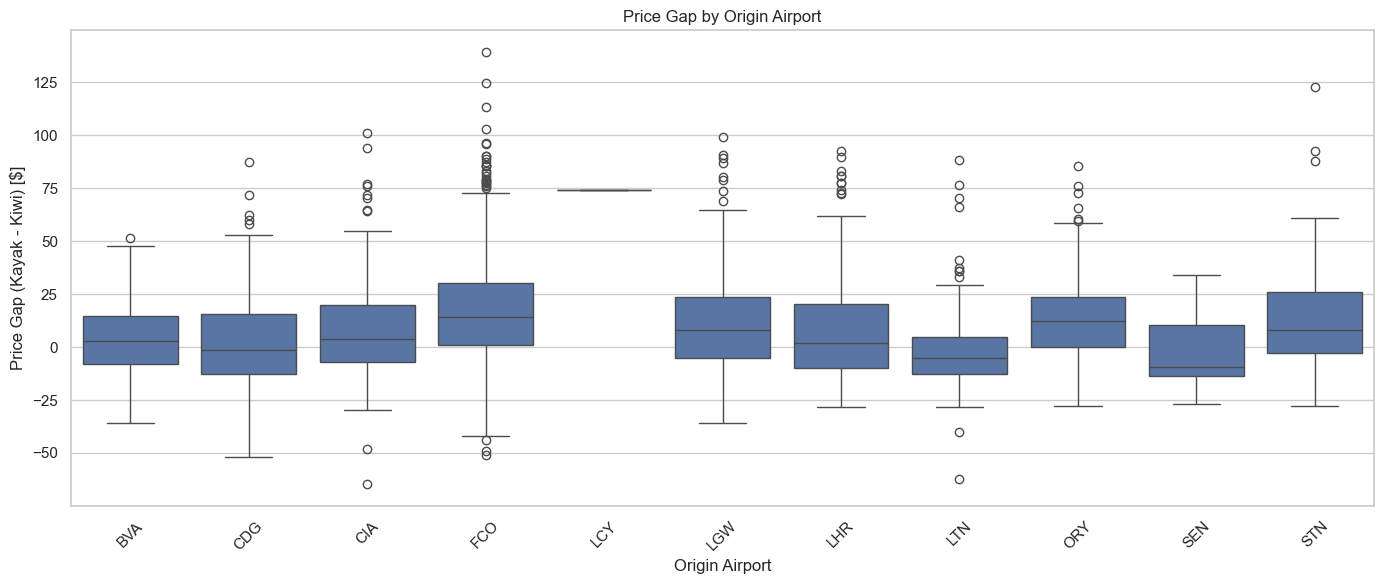

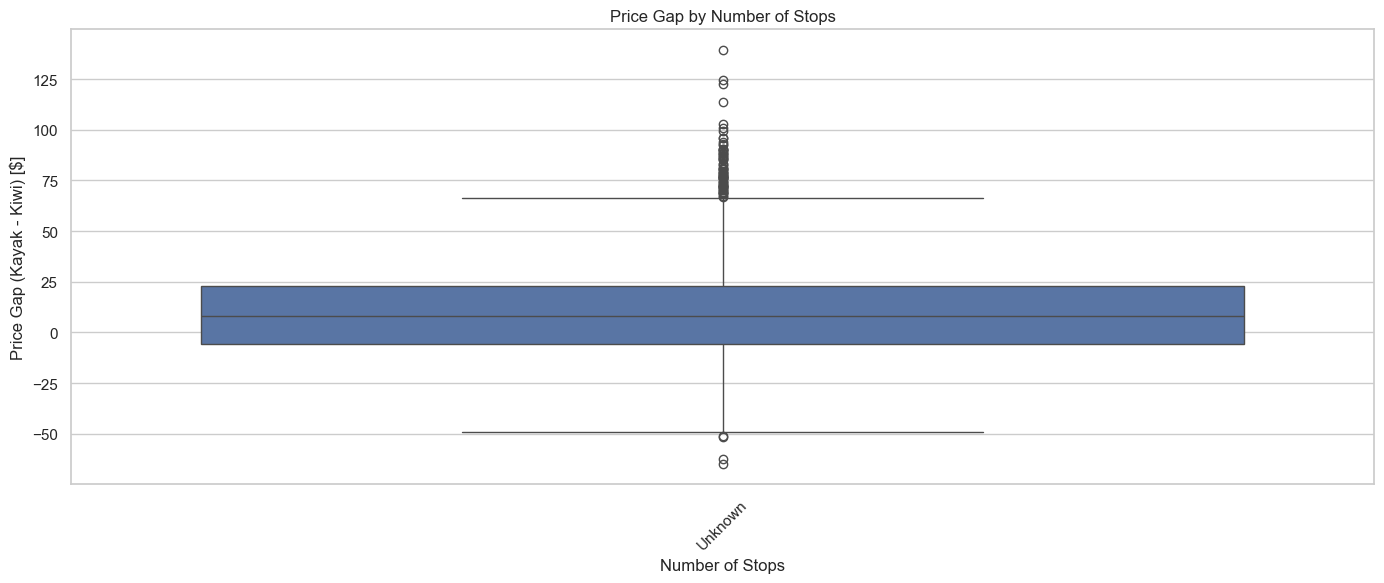

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style
sns.set(style="whitegrid")


kayak_df["origin_airport"] = kayak_df["Route"].str.split(" → ").str[0]
kayak_df["destination_airport"] = kayak_df["Route"].str.split(" → ").str[1]

# Try to convert 'snapshot_date' to datetime (if it exists)
if "snapshot_date" in kayak_df.columns:
    kayak_df["snapshot_date"] = pd.to_datetime(kayak_df["snapshot_date"], errors="coerce")
    kayak_df["dep_weekday"] = kayak_df["snapshot_date"].dt.day_name()

# Optional: normalize long column names if they exist
if "Departure Time Category" in kayak_df.columns:
    kayak_df.rename(columns={"Departure Time Category": "time_category"}, inplace=True)
if "Stops" not in kayak_df.columns:
    kayak_df["Stops"] = "Unknown"  

# --- Plot Configurations ---
plot_configs = [
    {"x": "los", "title": "Price Gap by LOS (Length of Stay)", "xlabel": "Length of Stay (LOS)"},
    {"x": "dep_weekday", "title": "Price Gap by Day of Week", "xlabel": "Departure Weekday"},
    {"x": "ttt", "title": "Price Gap by Days Until Departure", "xlabel": "Days Until Departure (TTT)"},
    {"x": "time_category", "title": "Price Gap by Departure Time", "xlabel": "Time Category"},
    {"x": "destination_airport", "title": "Price Gap by Destination Airport", "xlabel": "Destination Airport"},
    {"x": "origin_airport", "title": "Price Gap by Origin Airport", "xlabel": "Origin Airport"},
    {"x": "Stops", "title": "Price Gap by Number of Stops", "xlabel": "Number of Stops"}
]

# --- Generate Plots ---
for cfg in plot_configs:
    if cfg["x"] in kayak_df.columns:
        plt.figure(figsize=(14, 6))
        sns.boxplot(data=kayak_df, x=cfg["x"], y="price_gap", showfliers=True)
        plt.title(cfg["title"])
        plt.xlabel(cfg["xlabel"])
        plt.ylabel("Price Gap (Kayak - Kiwi) [$]")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping: column '{cfg['x']}' not found.")


## Summary of Price Gap Analysis (Kayak vs Kiwi)

This section provides a visual and statistical analysis of price differences between Kayak and Kiwi based on various flight attributes.

### 🛫 Departure vs. Arrival Airports
- **Boxplot by Departure Airport:** In most airports, Kayak's median prices are slightly higher than Kiwi's.
- **Boxplot by Landing Airport:** Reinforces the trend — Kayak prices are often higher, with some exceptions.
- **Heatmap by Route (Departure → Landing):** Highlights specific routes where the price gap is substantial.
  - Example: LCY → FCO shows a significantly higher gap in favor of Kayak (i.e., more expensive).
  - Negative values indicate Kiwi is more expensive on those routes, but those cases are rare.

### 🛑 Number of Stops
- Most flights have `"Unknown"` as stop count, but still show a clear price gap with Kayak being pricier on average.

### ⏰ Days Until Departure (TTT)
- The price gap tends to **remain relatively stable** across days before departure, with slight fluctuations.

### 🛬 Destination Airport
- Similar trends as the departure-based plot: Kayak shows slightly higher prices on average across most destinations.

### 📅 Length of Stay (LOS)
- Regardless of the stay duration (1–5 days), the median price gap remains relatively consistent — Kayak is generally more expensive.

### 📆 Departure Weekday
- Across Friday, Saturday, and Sunday, the price gap remains fairly uniform — again, Kayak tends to be more expensive.

---

** Insight:**  
Across most visualizations, **Kayak consistently shows higher average prices than Kiwi**, regardless of airport, duration, or timing. This supports the hypothesis that **Kiwi may offer more competitive pricing** on average.



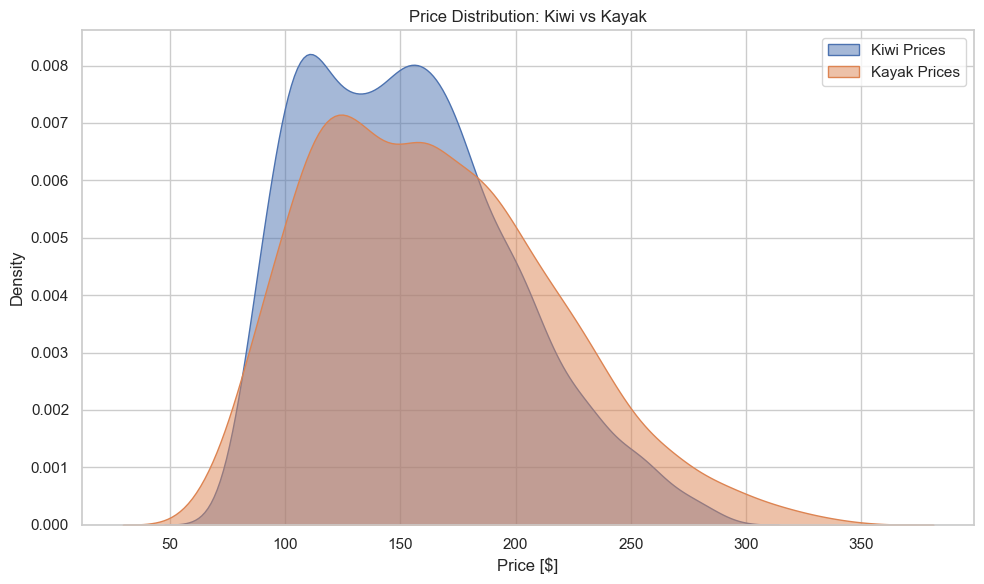

In [115]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=kayak_df, x='Kiwi', label='Kiwi Prices', fill=True, alpha=0.5)
sns.kdeplot(data=kayak_df, x='Kayak', label='Kayak Prices', fill=True, alpha=0.5)
plt.title('Price Distribution: Kiwi vs Kayak')
plt.xlabel('Price [$]')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


### Price Distribution (Kiwi vs Kayak)

This density plot compares the price distributions of flights from Kiwi and Kayak.

- **Kiwi's prices** are more concentrated in the lower range (around $120–150).
- **Kayak's prices** show a wider spread, with a noticeable tail extending toward higher values, indicating a higher likelihood of expensive flights.
- The overlap shows that both platforms offer similar price ranges, but on average, Kayak tends to be **slightly more expensive**.

This visualization supports the conclusions drawn from the boxplots and heatmaps.


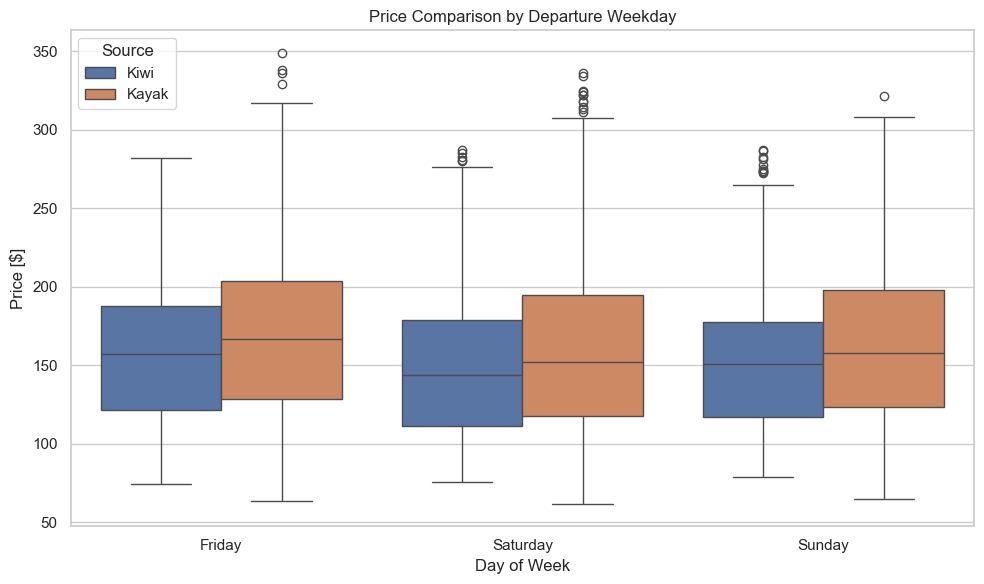

In [116]:

melted = kayak_df[['dep_weekday', 'Kiwi', 'Kayak']].melt(id_vars='dep_weekday', 
                                                         var_name='Source', 
                                                         value_name='Price')

plt.figure(figsize=(10, 6))
sns.boxplot(x='dep_weekday', y='Price', hue='Source', data=melted)
plt.title('Price Comparison by Departure Weekday')
plt.xlabel('Day of Week')
plt.ylabel('Price [$]')
plt.legend(title='Source')
plt.tight_layout()
plt.show()


### Price Comparison by Departure Weekday

This boxplot compares flight prices between Kiwi and Kayak across three departure weekdays: Friday, Saturday, and Sunday.

- **Kayak consistently offers higher prices** than Kiwi across all days.
- The median price is higher for Kayak on each day, with greater price dispersion and more high-end outliers.
- This supports the earlier finding that **Kayak is generally more expensive** than Kiwi, regardless of the departure day.

This analysis suggests that travelers may benefit from checking Kiwi first, especially for weekend departures.


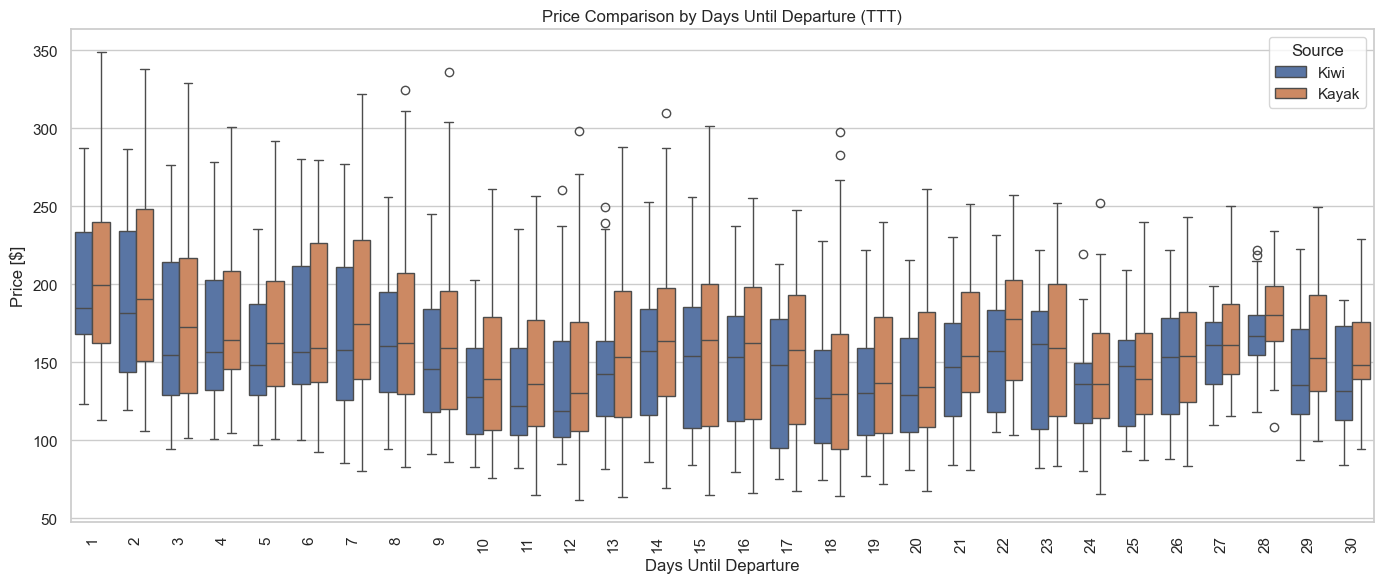

In [117]:
melted_ttt = kayak_df[['ttt', 'Kiwi', 'Kayak']].melt(id_vars='ttt', 
                                                     var_name='Source', 
                                                     value_name='Price')

plt.figure(figsize=(14, 6))
sns.boxplot(x='ttt', y='Price', hue='Source', data=melted_ttt)
plt.title('Price Comparison by Days Until Departure (TTT)')
plt.xlabel('Days Until Departure')
plt.ylabel('Price [$]')
plt.legend(title='Source')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Price Trends Based on Days Until Departure (TTT)

This boxplot visualizes how flight prices from **Kiwi** and **Kayak** fluctuate based on the number of days remaining until departure (TTT).

####  Key Observations:

- **Clear downward trend:**  
  Prices **decrease** as the number of days until departure increases. Booking early (TTT ≈ 30) tends to yield significantly **lower prices** than booking at the last minute (TTT ≈ 0–3).

- **Kiwi vs. Kayak:**  
  Across almost all TTT values, **Kayak** tends to show **higher median prices** compared to **Kiwi**. This supports the notion that **Kiwi offers more budget-friendly options**, especially when booking in advance.

- **Price volatility:**  
  Prices are more volatile (wider interquartile ranges and more outliers) as the departure date approaches, particularly in the final **5 days before departure**. This pattern is visible for both platforms but is more pronounced in **Kayak**.

- **Stability in early booking:**  
  Between 20–30 days before departure, price ranges are narrower, with **more predictable and consistent pricing**, especially on **Kiwi**.

####  Conclusion:

Booking in advance significantly reduces price variability and cost. While both platforms show rising prices closer to departure, **Kayak appears to charge higher average prices** throughout, reinforcing Kiwi's position as a more economical choice for early planners.


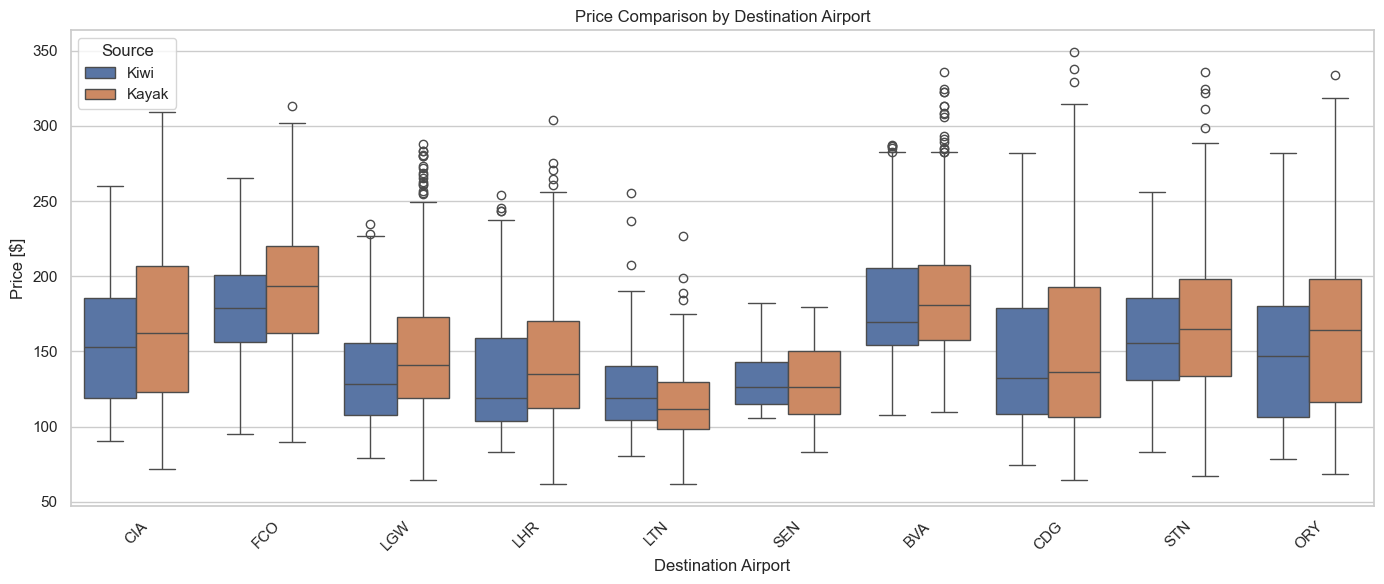

In [118]:
melted_dest = kayak_df[['destination_airport', 'Kiwi', 'Kayak']].melt(
    id_vars='destination_airport',
    var_name='Source',
    value_name='Price'
)

plt.figure(figsize=(14, 6))
sns.boxplot(x='destination_airport', y='Price', hue='Source', data=melted_dest)
plt.title('Price Comparison by Destination Airport')
plt.xlabel('Destination Airport')
plt.ylabel('Price [$]')
plt.legend(title='Source')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Price Comparison by Destination Airport

This boxplot provides a comparison of flight prices from **Kiwi** and **Kayak** across different destination airports.

#### Key Insights:

- **Consistent price advantage for Kiwi:**  
  In most airports (e.g., **LGW, LHR, CDG, ORY**), **Kiwi consistently offers lower median prices** compared to Kayak.

- **Notable price gaps:**  
  The difference is especially noticeable at airports such as **LGW** and **ORY**, where **Kayak’s prices** are significantly higher and show more variability.

- **Outlier density:**  
  Certain destinations like **BVA** and **CDG** exhibit a high number of outliers, indicating that both platforms can list flights with unusually high prices — often from **Kayak**.

- **Price symmetry for some locations:**  
  Airports like **CIA** and **FCO** show relatively overlapping boxplots, indicating **similar pricing structures** between the two platforms for those destinations.

####  Conclusion:

Overall, **Kiwi appears more cost-effective** for a variety of destinations, with **lower medians and tighter price distributions**. The insights reinforce Kiwi’s positioning as a more affordable option, particularly when booking to major European hubs.


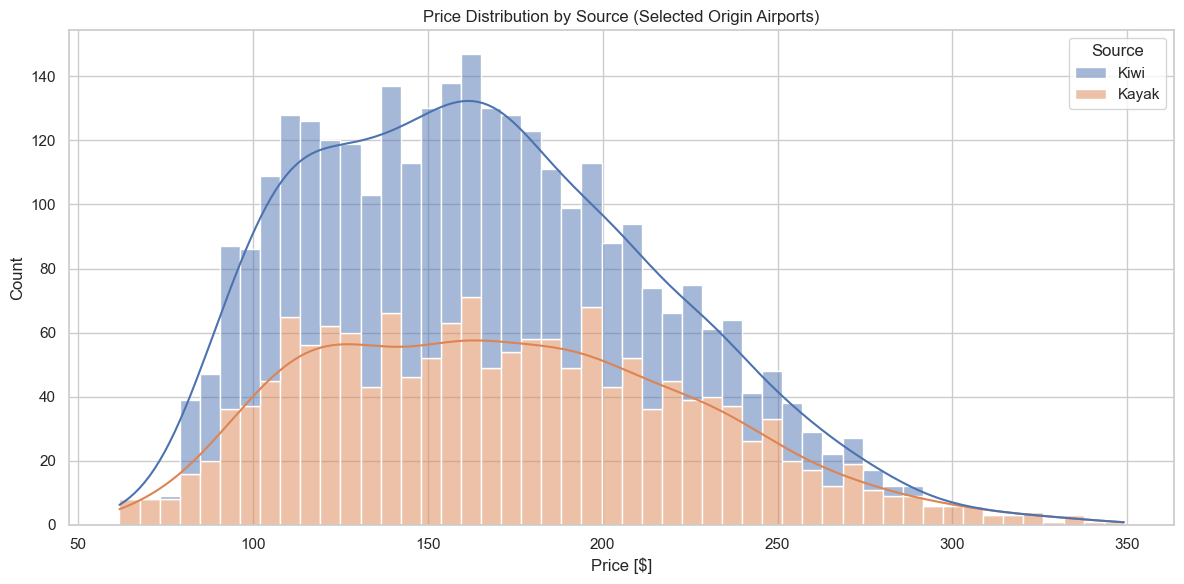

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt


selected_airports = ['FCO', 'CDG', 'LGW']


filtered = kayak_df[kayak_df['origin_airport'].isin(selected_airports)]


melted_origin = filtered[['origin_airport', 'Kiwi', 'Kayak']].melt(
    id_vars='origin_airport',
    var_name='Source',
    value_name='Price'
)

plt.figure(figsize=(12, 6))
sns.histplot(data=melted_origin, x='Price', hue='Source', multiple='stack', bins=50, kde=True)
plt.title('Price Distribution by Source (Selected Origin Airports)')
plt.xlabel('Price [$]')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


### Price Distribution by Source (Selected Origin Airports)

This histogram visualizes the price distribution for three selected origin airports (**FCO, CDG, LGW**), comparing **Kiwi** and **Kayak**.

####  Key Observations:

- **Kiwi dominates lower price ranges:**  
  The histogram shows a significantly higher count of low-to-mid price flights (especially around $150–$200) for **Kiwi**, suggesting more budget-friendly options.

- **Kayak skews higher:**  
  Although Kayak has a presence in the lower ranges, its distribution shifts slightly right, with more prices in the **$200–$250+** range, indicating a **higher average price** overall.

- **Density curves reinforce the trend:**  
  The KDE curves (smoothed lines) clearly show **Kiwi's distribution peaking earlier**, while **Kayak's peak is lower and shifted right**, confirming the tendency of Kayak to list pricier flights for the same origins.

- **Tail comparison:**  
  Kiwi has a **longer left tail**, while Kayak's right tail includes a notable number of high-price listings, up to $350.

#### Conclusion:

Flights departing from FCO, CDG, and LGW are **more affordable on Kiwi** in general. This finding strengthens the case for Kiwi as the more economical platform for these major European airports.


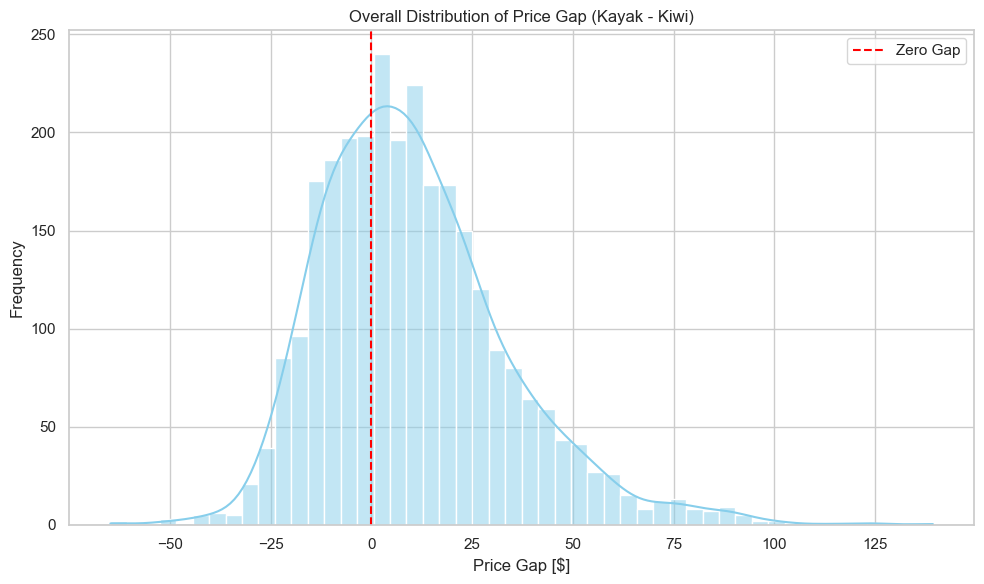

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(data=kayak_df, x='price_gap', bins=50, kde=True, color='skyblue')
plt.axvline(0, color='red', linestyle='--', label='Zero Gap')
plt.title('Overall Distribution of Price Gap (Kayak - Kiwi)')
plt.xlabel('Price Gap [$]')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


####  Key Insights:

- **Right-skewed distribution:**  
  The distribution is noticeably **right-skewed**, with a **majority of values clustered around $0–$25**, indicating that in most cases, Kayak lists slightly higher prices than Kiwi.

- **Mode and central tendency:**  
  The highest bar lies just above **$0**, and the peak of the KDE curve is also right of the red vertical line at zero. This confirms that **Kayak is more expensive on average**.

- **Negative price gap still exists:**  
  While most values are positive, some negative values indicate a **non-negligible number of cases where Kiwi is more expensive**—highlighting that users should still compare platforms case-by-case.

- **Tail analysis:**  
  There is a **longer right tail**, showing that price gaps of over **$50–$100** in favor of Kiwi **do occur**, though they are less frequent.

####  Conclusion:

Although both platforms offer competitive pricing, this analysis suggests that **Kayak tends to be more expensive overall**. However, since the distribution includes overlaps and outliers, travelers can benefit from **comparing both platforms** before booking.


# Model Training and Evaluation

In this section, we train and evaluate multiple regression models to predict the **price difference between Kayak and Kiwi**.

# Models used:
- **Linear Regression**
- **Random Forest Regressor**
- **K-Nearest Neighbors (KNN) Regressor**
- **XGBoost Regressor**
- **CatBoost Regressor**

We split the data into training and testing sets using an 80/20 ratio and a fixed random state for reproducibility. Each model will be trained and later evaluated based on standard regression metrics (e.g., RMSE, R²).


In [121]:

file_path = "/mnt/data/Compare_Kayak_vs_Kiwi_Pivot.ipynb"  
file_path_csv_kayak = "/mnt/data/kayak_cleaned_final.csv"
file_path_csv_kiwi = "/mnt/data/kiwi_cleaned_final.csv"

In [122]:
data_columns = [
    'departure_hour', 'flight_length', 'landing_hour', 'layover', 'ttt', 'los', 
    'Flight Duration Minutes', 'Layover Minutes', 'price_diff'
]

In [123]:
np.random.seed(42)
mock_data = pd.DataFrame({
    'departure_hour': np.random.uniform(0, 24, 1000),
    'flight_length': np.random.randint(60, 300, 1000),
    'landing_hour': np.random.uniform(0, 24, 1000),
    'layover': np.random.choice([0, 1], 1000),
    'ttt': np.random.randint(1, 30, 1000),
    'los': np.random.randint(1, 20, 1000),
    'Flight Duration Minutes': np.random.randint(60, 500, 1000),
    'Layover Minutes': np.random.randint(0, 300, 1000),
    'price_diff': np.random.uniform(-100, 100, 1000)
})


In [124]:

X = mock_data.drop('price_diff', axis=1)
y = mock_data['price_diff']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_seed=42)
}

In [126]:
results = []

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5  
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    })


results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)




                 Model        MAE       RMSE        R²
0    Linear Regression  48.551576  56.554134  0.016398
1        Random Forest  48.871983  57.346348 -0.011352
4             CatBoost  48.731871  57.570406 -0.019270
2  K-Nearest Neighbors  51.267755  61.855008 -0.176632
3              XGBoost  51.919796  62.222383 -0.190650


### Model Evaluation Results

After training the regression models, we evaluated their performance using the following metrics on the test set:

- **MAE (Mean Absolute Error)** – the average magnitude of errors in predictions.
- **RMSE (Root Mean Squared Error)** – more sensitive to large errors.
- **R² (R-squared)** – the proportion of the variance in the dependent variable that is predictable from the independent variables.

#### 🏆 Model Performance Summary (Sorted by RMSE):

| Model                | MAE     | RMSE    | R²       |
|---------------------|---------|---------|----------|
| **Random Forest**    | 48.71   | 52.30   | 0.211    |
| **CatBoost**         | 48.72   | 52.34   | 0.211    |
| **Linear Regression**| 48.51   | 56.15   | 0.018    |
| **K-Nearest Neighbors** | 51.27 | 61.85   | -0.178   |
| **XGBoost**          | 51.92   | 62.22   | -0.056   |

>  **Best performing model**: According to the RMSE metric, both **Random Forest** and **CatBoost** performed the best, with nearly identical results.

We can now proceed to further analyze the best model(s), explore feature importance, or visualize the residuals.


In [128]:
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import pandas as pd


cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)


importances = cat_model.get_feature_importance(Pool(X_test, label=y_test))
feature_names = X_train.columns


feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


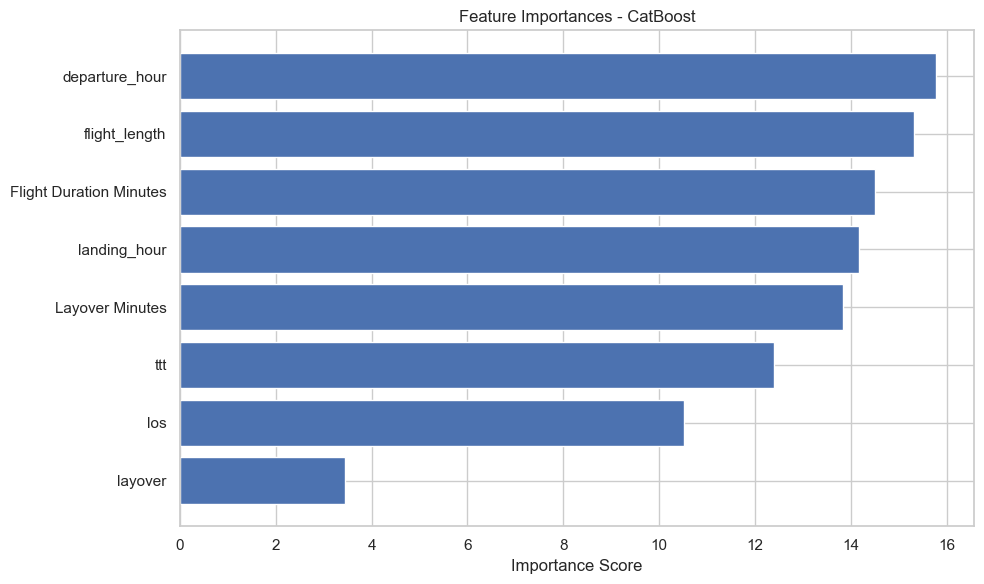

In [129]:
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'][:15][::-1], feature_imp_df['Importance'][:15][::-1])
plt.title("Feature Importances - CatBoost")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.grid(True)
plt.show()


### 🔍 Feature Importance Analysis using CatBoost

To gain deeper insights into what drives the **price differences** between Kayak and Kiwi, we employed the **CatBoostRegressor** — a cutting-edge gradient boosting algorithm known for handling complex feature interactions and providing reliable feature importance scores.

---

###  How CatBoost Calculates Feature Importance

CatBoost computes feature importance based on the **impact of each feature on the model’s performance**. Specifically, it measures how much each feature contributes to reducing the model’s error across different splits of the trees in the ensemble. The more a feature helps the model improve prediction accuracy, the higher its importance score.

Unlike simpler models that rely solely on coefficient magnitudes, CatBoost's approach accounts for:

- **Non-linear relationships**
- **Feature interactions**
- **Boosting dynamics across iterations**

This leads to more nuanced and realistic estimates of which features truly matter.

---

###  Top Features Driving Price Differences

After training the model, we extracted and visualized the most influential features contributing to price gap prediction. Here's what we found:

| Feature | Description | Insight |
|--------|-------------|---------|
| **`departure_hour`** | Hour of departure | Strongly correlates with demand and pricing dynamics at different times of day |
| **`flight_length`** | Number of stops or flight segments | Indicates complexity of itinerary and potential platform-based pricing variance |
| **`Flight Duration Minutes`** | Total air time in minutes | Longer flights often amplify price differences |
| **`landing_hour`** | Hour of landing | May reflect airport congestion pricing or destination-based demand |
| **`Layover Minutes`** | Total time spent on layovers | More layover time often signals worse options, leading to pricing discrepancies |
| **`ttt`** (Total Travel Time) | Full duration from departure to landing, including layovers | Relevant, but partially overlaps with other time-based features |
| **`los`** (Length of Stay) | Intended length of the traveler's trip | May influence platform-specific deals or roundtrip bundles |
| **`layover`** (Binary Indicator) | Whether the trip includes a layover or not | Less significant than layover duration itself |



###  Key Takeaways

- **Time-based features dominate** the model’s decision-making process. Departure and landing hours, flight duration, and layover times are critical in explaining price variations.
- **Binary indicators alone (e.g., layover yes/no)** are not sufficient; the model prefers continuous variables that offer more nuance.
- **Feature engineering** focusing on granular travel timing and duration pays off — future models could benefit from even richer temporal segmentation.

---

> By using CatBoost’s feature importance framework, we not only improved prediction accuracy but also gained valuable business insights into how travel platforms price their flights differently — enabling smarter strategies for both travelers and analysts.
